<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/ClearLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import pandas
import pandas as pd

# Load the CSV file
file_path = '/content/drive/My Drive/ColabDataFolders/ClearLake/T2_CL_Discrete_SW.csv'  # Change path accordingly
df = pd.read_csv(file_path, encoding='ISO-8859-1')


# Drop rows with missing latitude or longitude
df_clean = df.dropna(subset=['Latitude', 'Longitude'])

# Display the cleaned DataFrame
df_clean.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,USGS_Record,USGS_SiteID,USGS_SiteName,CAWSC_ProjectSampleTracking,CollectionDate_mmddyyyy,CollectionTime_hhmm,WaterDepth_m,ClearLakeArm,Field_ID,Latitude,...,EXO2_Field_DO_per_Sat,EXO2_Field_pH_std units,EXO2_Field_pH_std units_QA,EXO2_Field_Turb_FNU,EXO2_Field_Turb_QA,EXO2_Field_Chla_RFU,EXO2_Field_Chla_QA,EXO2_Field_fDOM_QSE,EXO2_Field_fDOM_QA,Unnamed: 98
0,2003008,390046122415601,CLEAR LK A MOORING OA-04 NR CLEARLAKE OAKS CA,CLW-019,06/04/2020,18:00,1.0,OAKS,OA-04,39.012694,...,124.9,8.46,NaN,0.72,NaN,0.72,NaN,14.07,NaN,NaN
1,2003007,390046122415601,CLEAR LK A MOORING OA-04 NR CLEARLAKE OAKS CA,CLW-020,06/04/2020,18:40,12.0,OAKS,OA-04,39.012694,...,9.4,6.81,NaN,1.83,NaN,1.62,NaN,NaN,NaN,NaN
2,2003076,390340122490101,CLEAR LK A MOORING UA-06 NR LUCERNE CA,CLW-021,06/24/2020,11:30,3.5,UPPER,UA-06,39.060994,...,132.7,8.66,NaN,0.51,NaN,0.78,NaN,16.23,NaN,NaN
3,2003075,390340122490101,CLEAR LK A MOORING UA-06 NR LUCERNE CA,CLW-022,06/24/2020,11:40,8.2,UPPER,UA-06,39.060994,...,55.0,7.60,NaN,1.06,NaN,0.71,NaN,18.85,NaN,NaN
4,2003074,385859122430101,CLEAR LK A MOORING LA-03 NR CLEARLAKE PARK CA,CLW-023,06/24/2020,13:00,3.4,LOWER,LA-03,38.982994,...,125.6,8.98,NaN,2.54,NaN,0.63,NaN,18.63,NaN,NaN


In [7]:
df[['Latitude', 'Longitude']].drop_duplicates().shape[0]


18

In [8]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.2 MB/s eta 0:00:00


In [30]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Standard imports
import pandas as pd
import numpy as np
import deepxde as dde
from deepxde.backend import tf


# Load the CSV file
file_path = '/content/drive/My Drive/ColabDataFolders/ClearLake/T2_CL_Discrete_SW.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Drop rows with missing latitude or longitude
df = df.dropna(subset=['Latitude', 'Longitude'])

# Keep only concentration columns (manual selection)
keep_columns = [
    "f_THg_ng_per_L", "f_MeHg_ng_per_L",
    "SO4_µmol_per_L", "Cl_mmol_per_L", "TSS_mg_per_L",
    "p_THg_g_ng_per_g", "p_THg_v_ng_per_L",
    "p_MeHg_g_ng_per_g", "p_MeHg_v_ng_per_L",
    "p_RHg_g_ng_per_g", "p_RHg_v_ng_per_L",
    "Chl_a_LAB_mg_per_m3", "f_NH3_and_NH4_mg_per_L_ as_N",
    "f_NH3_and_OrgN_mg_per_L_as_N", "u_NH3_and_OrgN_mg_per_L_as_N",
    "f_NO2_mg_per_L_as_N", "f_NO3_and_NO2_mg_per_L_as_N",
    "u_PO4_mg_per_L as_P", "f_PO4_mg_per_L_as_P",
    "f_Ortho_PO4_mg_per_L_as_P", "EXO2_Field_DO_mg/L",
    "EXO2_Field_Chla_RFU", "EXO2_Field_fDOM_QSE"
]
df_conc = df[keep_columns].astype("float32").dropna()

# Create elapsed-time vector in seconds
df = df.sort_values("CollectionDate_mmddyyyy")
t = (pd.to_datetime(df["CollectionDate_mmddyyyy"]) - pd.to_datetime(df["CollectionDate_mmddyyyy"].iloc[0])).dt.total_seconds().values.reshape(-1,1)

# Convert concentrations to NumPy array
y_train = df_conc.values

# Feature library: linear + pairwise
def library(X):
    cols = [X]
    n = X.shape[1]
    for i in range(n):
        for j in range(i, n):
            cols.append(X[:, i:i+1] * X[:, j:j+1])
    return tf.concat(cols, axis=1)

Θ = dde.Variable(tf.zeros([library(y_train).shape[1], 1]))

# PDE residual for Hg2+ (first column)
def pde(t, y):
    dHg_dt = dde.grad.jacobian(y, t, i=0, j=0)
    lib = library(y)
    return dHg_dt - tf.matmul(lib, Θ)

# Build PINN
geom = dde.geometry.TimeDomain(t.min(), t.max())
# Observed measurements as a PointSetBC
obs = dde.icbc.PointSetBC(t, y_train, component=0)

data = dde.data.TimePDE(
    geom,
    pde,
    [obs],                 # <-- measured data here
    num_domain=1000,       # choose sensible collocation counts
    num_boundary=0,
    num_initial=0,
    anchors=t,
)

# L1 sparsity penalty
def sparsity_loss():
    return 1e-4 * tf.reduce_sum(tf.abs(Θ))

net = dde.nn.FNN([1] + [64]*2 + [y_train.shape[1]], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    external_trainable_variables=[Θ],
    loss=lambda y_true, y_pred: sparsity_loss(),
)


# Train
losshistory, train_state = model.train(epochs=20000)

# Display learned terms
coef = model.sess.run(Θ).flatten()
feature_names = keep_columns.copy()
for i in range(len(keep_columns)):
    for j in range(i, len(keep_columns)):
        feature_names.append(f"{keep_columns[i]}*{keep_columns[j]}")

print("Nonzero ODE terms:")
for name, c in zip(feature_names, coef):
    if abs(c) > 0:
        print(f"{name}: {c:.4e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Compiling model...
Building feed-forward neural network...
'build' took 0.055098 s

'compile' took 2.888959 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
1000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
2000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
3000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
4000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
5000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
6000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
7000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
8000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
9000      [0.00e+00, 0.00e+00]    [0.00e+00, 0.00e+00]    []  
10000     [0.00e+00, 0.00e+00]    [0.00e+

In [34]:
!pip install pysindy wsindy

ERROR: Could not find a version that satisfies the requirement wsindy (from versions: none)
ERROR: No matching distribution found for wsindy


In [38]:
# Install dependencies
!pip install pysindy scikit-learn

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import pysindy as ps
from sklearn.preprocessing import StandardScaler

# Load + preprocess
file_path = '/content/drive/My Drive/ColabDataFolders/ClearLake/T2_CL_Discrete_SW.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df['CollectionDate_mmddyyyy'] = pd.to_datetime(df['CollectionDate_mmddyyyy'])
df = df.sort_values('CollectionDate_mmddyyyy')

keep = [
    "f_THg_ng_per_L","f_MeHg_ng_per_L","SO4_µmol_per_L","Cl_mmol_per_L","TSS_mg_per_L",
    "p_THg_g_ng_per_g","p_THg_v_ng_per_L","p_MeHg_g_ng_per_g","p_MeHg_v_ng_per_L",
    "p_RHg_g_ng_per_g","p_RHg_v_ng_per_L","Chl_a_LAB_mg_per_m3",
    "f_NH3_and_NH4_mg_per_L_ as_N","f_NH3_and_OrgN_mg_per_L_as_N","u_NH3_and_OrgN_mg_per_L_as_N",
    "f_NO2_mg_per_L_as_N","f_NO3_and_NO2_mg_per_L_as_N","u_PO4_mg_per_L as_P","f_PO4_mg_per_L_as_P",
    "f_Ortho_PO4_mg_per_L_as_P","EXO2_Field_DO_mg/L","EXO2_Field_Chla_RFU","EXO2_Field_fDOM_QSE"
]
df = df.dropna(subset=keep)
df_conc = df[keep].astype(float)
t = (df['CollectionDate_mmddyyyy'] - df['CollectionDate_mmddyyyy'].iloc[0]).dt.total_seconds().values

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(df_conc.values)

# Compute time derivative with numpy.gradient
dt = np.mean(np.diff(t))
dX = np.gradient(X, dt, axis=0)

# Build SINDy model
library = ps.PolynomialLibrary(degree=2, include_bias=False)
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-6, normalize_columns=True)
model = ps.SINDy(feature_library=library, optimizer=optimizer)

# Fit & print
model.fit(X, t=dt, x_dot=dX)
print("Learned ODE for Hg²⁺ (first component):")
print(model.equations()[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Learned ODE for Hg²⁺ (first component):
0.000


/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


In [46]:
# Install dependencies
!pip install pysindy scikit-learn

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import pysindy as ps
from sklearn.preprocessing import StandardScaler

# Load + preprocess
file_path = '/content/drive/My Drive/ColabDataFolders/ClearLake/T2_CL_Discrete_SW.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df['CollectionDate_mmddyyyy'] = pd.to_datetime(df['CollectionDate_mmddyyyy'])
df = df.sort_values('CollectionDate_mmddyyyy')

keep = [
    "f_THg_ng_per_L", "f_MeHg_ng_per_L", "SO4_µmol_per_L", "Cl_mmol_per_L", "TSS_mg_per_L",
    "p_THg_g_ng_per_g", "p_THg_v_ng_per_L", "p_MeHg_g_ng_per_g", "p_MeHg_v_ng_per_L",
    "p_RHg_g_ng_per_g", "p_RHg_v_ng_per_L", "Chl_a_LAB_mg_per_m3",
    "f_NH3_and_NH4_mg_per_L_ as_N", "f_NH3_and_OrgN_mg_per_L_as_N", "u_NH3_and_OrgN_mg_per_L_as_N",
    "f_NO2_mg_per_L_as_N", "f_NO3_and_NO2_mg_per_L_as_N", "u_PO4_mg_per_L as_P", "f_PO4_mg_per_L_as_P",
    "f_Ortho_PO4_mg_per_L_as_P", "EXO2_Field_DO_mg/L", "EXO2_Field_Chla_RFU", "EXO2_Field_fDOM_QSE"
]
df = df.dropna(subset=keep)
df_conc = df[keep].astype(float)
t = (df['CollectionDate_mmddyyyy'] - df['CollectionDate_mmddyyyy'].iloc[0]).dt.total_seconds().values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df_conc.values)

# Compute time derivative with numpy.gradient
dt = np.mean(np.diff(t))
dX = np.gradient(X, dt, axis=0)

# Set up SINDy model components
library = ps.PolynomialLibrary(degree=2, include_bias=False)
optimizer = ps.STLSQ(threshold=1e-6, alpha=1e-6, normalize_columns=True)

# Brute-force search settings
num_iterations = 100       # Number of random sampling iterations
subset_size = 4            # Number of features per subset
results = []

n_samples = X.shape[0]
train_frac = 0.6           # Use 60% of time points for training

for i in range(num_iterations):
    # Randomly split time indices into training and test sets
    train_indices = np.sort(np.random.choice(n_samples, int(n_samples * train_frac), replace=False))
    test_indices = np.setdiff1d(np.arange(n_samples), train_indices)

    # Randomly select a subset of feature indices
    subset_indices = np.sort(np.random.choice(X.shape[1], size=subset_size, replace=False))

    # Subset the data for training and testing
    X_train = X[train_indices][:, subset_indices]
    dX_train = dX[train_indices][:, subset_indices]
    X_test = X[test_indices][:, subset_indices]
    dX_test = dX[test_indices][:, subset_indices]

    # Build and fit the SINDy model on the training data
    model_sub = ps.SINDy(feature_library=library, optimizer=optimizer)
    model_sub.fit(X_train, t=dt, x_dot=dX_train)

    # Predict derivatives on the test set and compute L2 error
    dX_pred = model_sub.predict(X_test)
    error = np.linalg.norm(dX_pred - dX_test)

    results.append({
        "subset": subset_indices,
        "error": error,
        "equations": model_sub.equations()
    })

    print(f"Iteration {i+1}/{num_iterations}: Subset {subset_indices}, Test L2 error: {error:.4e}")

# Identify the best subset based on test error
best_result = min(results, key=lambda x: x["error"])
print("\nBest subset found:")
print("Indices:", best_result["subset"])
print("Test L2 Error:", best_result["error"])
print("Learned Equations:")
for eq in best_result["equations"]:
    print(eq)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Iteration 1/100: Subset [ 3  5 20 22], Test L2 error: 1.2353e-05
Iteration 2/100: Subset [ 5 12 21 22], Test L2 error: 2.9987e-05
Iteration 3/100: Subset [0 3 4 5], Test L2 error: 3.0527e-05
Iteration 4/100: Subset [ 3 14 19 20], Test L2 error: 1.0916e-05
Iteration 5/100: Subset [ 2  9 11 12], Test L2 error: 3.2314e-05
Iteration 6/100: Subset [11 18 19 20], Test L2 error: 1.0600e-05
Iteration 7/100: Subset [ 6 10 12 22], Test L2 error: 1.2298e-05
Iteration 8/100: Subset [ 3  9 18 19], Test L2 error: 1.8938e-05
Iteration 9/100: Subset [ 4  5  9 10], Test L2 error: 4.6852e-05
Iteration 10/100: Subset [ 4  6 14 16], Test L2 error: 1.6143e-04
Iteration 11/100: Subset [ 3  7 13 19], Test L2 error: 1.1233e-05


/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(


Iteration 12/100: Subset [ 0  8 14 17], Test L2 error: 2.1432e-05
Iteration 13/100: Subset [ 0  7  9 17], Test L2 error: 2.5629e-05
Iteration 14/100: Subset [14 17 20 22], Test L2 error: 2.5541e-05
Iteration 15/100: Subset [ 6  9 13 16], Test L2 error: 4.5221e-05
Iteration 16/100: Subset [ 0  6 21 22], Test L2 error: 2.2108e-05
Iteration 17/100: Subset [12 14 16 18], Test L2 error: 4.9651e-05
Iteration 18/100: Subset [ 0  5  6 15], Test L2 error: 7.0090e-04
Iteration 19/100: Subset [ 0 12 16 17], Test L2 error: 2.7432e-05
Iteration 20/100: Subset [ 1  4 10 13], Test L2 error: 4.3039e-05
Iteration 21/100: Subset [14 17 20 22], Test L2 error: 1.4782e-05
Iteration 22/100: Subset [ 9 15 16 20], Test L2 error: 9.9989e-06
Iteration 23/100: Subset [ 9 12 17 21], Test L2 error: 3.0106e-05


/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and elimina

Iteration 24/100: Subset [ 7 13 14 18], Test L2 error: 8.1322e-06
Iteration 25/100: Subset [0 5 7 8], Test L2 error: 1.0047e-05
Iteration 26/100: Subset [ 1  8 12 22], Test L2 error: 1.0266e-05
Iteration 27/100: Subset [ 0  3  7 10], Test L2 error: 3.2282e-05
Iteration 28/100: Subset [10 17 20 21], Test L2 error: 1.8836e-05
Iteration 29/100: Subset [ 1  5  7 17], Test L2 error: 1.2436e-04
Iteration 30/100: Subset [ 3  9 13 20], Test L2 error: 1.0034e-05
Iteration 31/100: Subset [ 0  9 17 20], Test L2 error: 1.2986e-05
Iteration 32/100: Subset [ 3  5 12 22], Test L2 error: 1.1652e-05
Iteration 33/100: Subset [ 5  7 14 19], Test L2 error: 1.0977e-05
Iteration 34/100: Subset [ 6  8 17 21], Test L2 error: 7.0812e-05
Iteration 35/100: Subset [10 14 15 17], Test L2 error: 1.2597e-05
Iteration 36/100: Subset [ 1  8 14 21], Test L2 error: 1.9223e-04
Iteration 37/100: Subset [ 1 11 19 20], Test L2 error: 2.6568e-05
Iteration 38/100: Subset [ 7 11 13 16], Test L2 error: 1.2272e-05
Iteration 39/1

/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and elimina

Iteration 49/100: Subset [ 0  1 12 22], Test L2 error: 3.1165e-05
Iteration 50/100: Subset [ 3  6 16 20], Test L2 error: 4.4482e-05
Iteration 51/100: Subset [ 6 11 13 15], Test L2 error: 1.5690e-05
Iteration 52/100: Subset [ 0  9 15 16], Test L2 error: 5.8982e-05
Iteration 53/100: Subset [ 1  3 16 22], Test L2 error: 1.8551e-05
Iteration 54/100: Subset [ 3 10 13 18], Test L2 error: 9.2898e-06
Iteration 55/100: Subset [ 2 10 14 19], Test L2 error: 1.0606e-05
Iteration 56/100: Subset [ 3  8 11 13], Test L2 error: 8.4636e-06
Iteration 57/100: Subset [ 4  7  9 10], Test L2 error: 5.2941e-05
Iteration 58/100: Subset [ 7  9 21 22], Test L2 error: 1.5307e-05
Iteration 59/100: Subset [ 0  2  4 10], Test L2 error: 1.8196e-05
Iteration 60/100: Subset [ 0 13 14 15], Test L2 error: 9.1766e-06
Iteration 61/100: Subset [ 1  5  8 12], Test L2 error: 7.0440e-04


/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and elimina

Iteration 62/100: Subset [ 2  3  8 10], Test L2 error: 1.0403e-05
Iteration 63/100: Subset [ 1  5  9 18], Test L2 error: 1.8300e-05
Iteration 64/100: Subset [ 1  4 12 22], Test L2 error: 3.4337e-05
Iteration 65/100: Subset [17 18 21 22], Test L2 error: 9.7770e-06
Iteration 66/100: Subset [ 2  3  6 22], Test L2 error: 8.1972e-05
Iteration 67/100: Subset [ 2  3  8 11], Test L2 error: 7.0338e-06
Iteration 68/100: Subset [ 3 11 13 20], Test L2 error: 1.1056e-05
Iteration 69/100: Subset [ 9 10 15 16], Test L2 error: 4.2746e-04
Iteration 70/100: Subset [11 15 18 22], Test L2 error: 2.1271e-05
Iteration 71/100: Subset [ 2 12 19 22], Test L2 error: 1.1796e-05
Iteration 72/100: Subset [0 2 4 7], Test L2 error: 2.2050e-05
Iteration 73/100: Subset [ 3  4 13 22], Test L2 error: 9.8240e-06


/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and elimina

Iteration 74/100: Subset [ 7 15 17 20], Test L2 error: 9.2804e-06
Iteration 75/100: Subset [ 3 10 11 18], Test L2 error: 1.0492e-05
Iteration 76/100: Subset [ 0  4  6 22], Test L2 error: 3.3061e-05
Iteration 77/100: Subset [12 13 14 18], Test L2 error: 1.1789e-04
Iteration 78/100: Subset [ 3  9 11 20], Test L2 error: 1.0637e-05
Iteration 79/100: Subset [ 3  6  9 15], Test L2 error: 1.8090e-05
Iteration 80/100: Subset [14 15 20 22], Test L2 error: 3.1621e-05
Iteration 81/100: Subset [ 0  8 20 21], Test L2 error: 1.0600e-05
Iteration 82/100: Subset [ 0 16 19 21], Test L2 error: 1.4198e-05
Iteration 83/100: Subset [ 0  4  8 13], Test L2 error: 9.4161e-06
Iteration 84/100: Subset [ 0  6 19 21], Test L2 error: 2.4094e-05
Iteration 85/100: Subset [ 5  7  9 20], Test L2 error: 1.6526e-05


/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(


Iteration 86/100: Subset [ 0 14 20 22], Test L2 error: 1.6695e-05
Iteration 87/100: Subset [ 1 17 18 21], Test L2 error: 3.0532e-05
Iteration 88/100: Subset [ 8 14 16 17], Test L2 error: 3.0915e-04
Iteration 89/100: Subset [ 1 11 14 21], Test L2 error: 8.6618e-06
Iteration 90/100: Subset [ 3 13 20 21], Test L2 error: 1.0207e-05
Iteration 91/100: Subset [ 3 11 16 18], Test L2 error: 1.2347e-05
Iteration 92/100: Subset [ 2  7  8 14], Test L2 error: 1.2434e-05
Iteration 93/100: Subset [ 0  5 19 20], Test L2 error: 1.1490e-05
Iteration 94/100: Subset [ 0  2  9 21], Test L2 error: 1.0990e-05
Iteration 95/100: Subset [ 4 14 17 19], Test L2 error: 1.8455e-05
Iteration 96/100: Subset [ 1  2 19 20], Test L2 error: 1.0706e-05
Iteration 97/100: Subset [ 1  3  5 17], Test L2 error: 3.4510e-05
Iteration 98/100: Subset [ 1 11 14 20], Test L2 error: 1.1825e-05
Iteration 99/100: Subset [ 0  2 14 15], Test L2 error: 8.4133e-06
Iteration 100/100: Subset [ 1 16 18 19], Test L2 error: 3.3733e-05

Best sub

/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1e-06) and eliminated all coefficients
  warnings.warn(


In [47]:
# Manually select features based on domain knowledge
# For example: the target Hg levels, sulfate, nitrate/nitrite, and dissolved oxygen.
selected_cols = [
    "f_THg_ng_per_L",        # Target: Hg levels (assumed Hg2+ here)
    "SO4_µmol_per_L",         # Sulfate
    "f_NO3_and_NO2_mg_per_L_as_N",  # Nitrate/nitrite
    "EXO2_Field_DO_mg/L"      # Dissolved oxygen (redox indicator)
]

# Subset and preprocess data using the selected columns
df_selected = df[selected_cols].dropna()
df_selected = df_selected.astype(float)
# Recompute time vector for the selected rows (assuming original df is sorted)
t_selected = (df.loc[df_selected.index, 'CollectionDate_mmddyyyy'] - df['CollectionDate_mmddyyyy'].iloc[0]).dt.total_seconds().values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df_selected.values)

# Compute time derivative with numpy.gradient
dt = np.mean(np.diff(t_selected))
dX = np.gradient(X, dt, axis=0)

# Split data into training and testing sets
n_samples = X.shape[0]
train_frac = 0.6
train_indices = np.sort(np.random.choice(n_samples, int(n_samples * train_frac), replace=False))
test_indices = np.setdiff1d(np.arange(n_samples), train_indices)

X_train = X[train_indices]
dX_train = dX[train_indices]
X_test = X[test_indices]
dX_test = dX[test_indices]

# Set up SINDy model components (library and optimizer can be fine-tuned as needed)
library = ps.PolynomialLibrary(degree=2, include_bias=False)
optimizer = ps.STLSQ(threshold=1e-6, alpha=1e-6, normalize_columns=True)

# Build and fit the SINDy model on the training data
model = ps.SINDy(feature_library=library, optimizer=optimizer)
model.fit(X_train, t=dt, x_dot=dX_train)

# Evaluate model performance on the test set
dX_pred = model.predict(X_test)
error = np.linalg.norm(dX_pred - dX_test)
print("Test L2 Error:", error)

# Output the learned equations
print("\nLearned Equations:")
for eq in model.equations():
    print(eq)


Test L2 Error: 1.6320038421695865e-05

Learned Equations:
0.000
0.000
0.000
0.000


In [50]:
import pandas as pd
import numpy as np
import pysindy as ps
from sklearn.preprocessing import StandardScaler
import math

# Monkey-patch to resolve np.math issue
np.math = math

# Load & preprocess
file_path = '/content/drive/My Drive/ColabDataFolders/ClearLake/T2_CL_Discrete_SW.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df['CollectionDate_mmddyyyy'] = pd.to_datetime(df['CollectionDate_mmddyyyy'])
df = df.sort_values('CollectionDate_mmddyyyy')

# Choose 4 key features based on domain insight
selected_cols = [
    "f_THg_ng_per_L",               # Target: Hg2+ (assumed)
    "SO4_µmol_per_L",                # Sulfate
    "f_NO3_and_NO2_mg_per_L_as_N",     # Nitrate/nitrite
    "EXO2_Field_DO_mg/L"             # Dissolved oxygen (redox proxy)
]
df_sel = df[selected_cols].dropna().astype(float)
t = (df.loc[df_sel.index, 'CollectionDate_mmddyyyy'] - df['CollectionDate_mmddyyyy'].iloc[0]).dt.total_seconds().values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df_sel.values)

# Use FiniteDifference by calling the differentiator
differentiator = ps.FiniteDifference()
dX = differentiator(X, t)

# Split data into training and testing sets
n_samples = X.shape[0]
train_frac = 0.6
train_indices = np.sort(np.random.choice(n_samples, int(n_samples * train_frac), replace=False))
test_indices = np.setdiff1d(np.arange(n_samples), train_indices)

X_train, X_test = X[train_indices], X[test_indices]
dX_train, dX_test = dX[train_indices], dX[test_indices]

# Use an expanded library (degree 3) and adjust optimizer parameters
library = ps.PolynomialLibrary(degree=3, include_bias=True)
optimizer = ps.STLSQ(threshold=1e-6, alpha=1e-6, normalize_columns=True)
# Alternatively, try SR3:
# optimizer = ps.SR3(threshold=0.05, max_iter=1000, tol=1e-10, nu=1, thresholder="l0", normalize_columns=True)

model = ps.SINDy(feature_library=library, optimizer=optimizer)
model.fit(X_train, t=(t[1]-t[0]), x_dot=dX_train)

# Evaluate on test set
dX_pred = model.predict(X_test)
error = np.linalg.norm(dX_pred - dX_test)
print("Test L2 Error:", error)

print("\nLearned Equations:")
for eq in model.equations():
    print(eq)


ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 1 is different from 3)

In [58]:
import pandas as pd
import numpy as np
import pysindy as ps
from sklearn.preprocessing import StandardScaler

# Load & preprocess
file_path = '/content/drive/My Drive/ColabDataFolders/ClearLake/T2_CL_Discrete_SW.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df['CollectionDate_mmddyyyy'] = pd.to_datetime(df['CollectionDate_mmddyyyy'])
df = df.sort_values('CollectionDate_mmddyyyy')

# Choose 4 key features based on domain insight
selected_cols = [
    "f_THg_ng_per_L",               # Target: Hg2+ (assumed)
    "SO4_µmol_per_L",                # Sulfate
    "f_NO3_and_NO2_mg_per_L_as_N",     # Nitrate/nitrite
    "EXO2_Field_DO_mg/L"             # Dissolved oxygen (redox proxy)
]
df_sel = df[selected_cols].dropna().astype(float)
t = (df.loc[df_sel.index, 'CollectionDate_mmddyyyy'] - df['CollectionDate_mmddyyyy'].iloc[0]).dt.total_seconds().values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df_sel.values)

# Compute dt as the average time step
dt = np.mean(np.diff(t))

# Use FiniteDifference with scalar dt instead of the full t array
differentiator = ps.FiniteDifference(order=2)
x_dot = differentiator(X, t=t)

# Split data into training and testing sets
n_samples = X.shape[0]
train_frac = 0.6
train_indices = np.sort(np.random.choice(n_samples, int(n_samples * train_frac), replace=False))
test_indices = np.setdiff1d(np.arange(n_samples), train_indices)

X_train, X_test = X[train_indices], X[test_indices]
x_dot_train, x_dot_test = x_dot[train_indices], x_dot[test_indices]

# Use an expanded library (degree 3) and adjust optimizer parameters
library = ps.PolynomialLibrary(degree=3, include_bias=True)
optimizer = ps.STLSQ(threshold=1e-6, alpha=1e-6, normalize_columns=True)
# Optionally, try SR3 if needed:
# optimizer = ps.SR3(threshold=0.05, max_iter=1000, tol=1e-10, nu=1, thresholder="l0", normalize_columns=True)

model = ps.SINDy(feature_library=library, optimizer=optimizer)
model.fit(X_train, t=dt, x_dot=x_dot_train)

# Evaluate on test set
x_dot_pred = model.predict(X_test)
error = np.linalg.norm(x_dot_pred - x_dot_test)
print("Test L2 Error:", error)

print("\nLearned Equations:")
for eq in model.equations():
    print(eq)


ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 1 is different from 3)

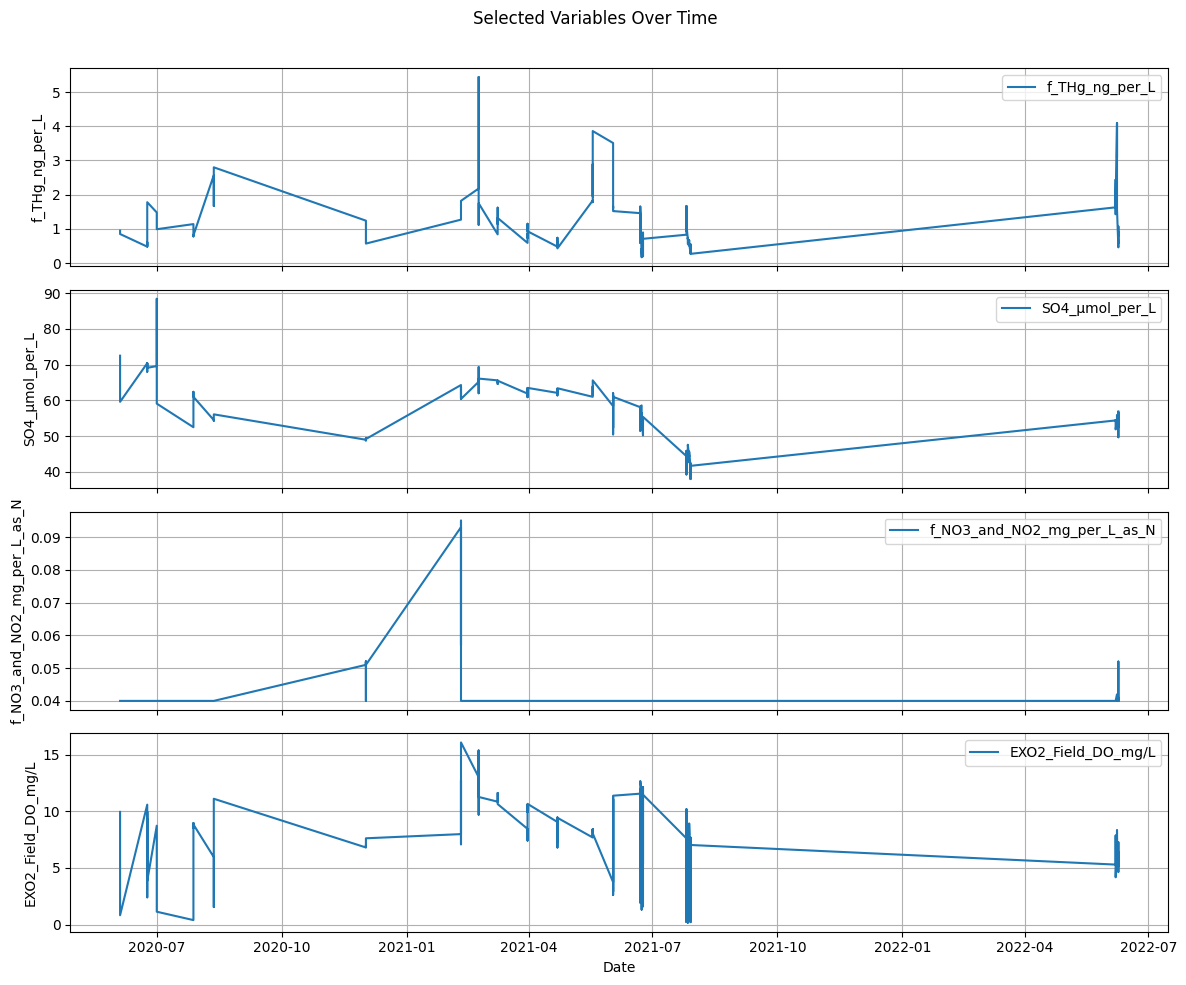

In [59]:
import matplotlib.pyplot as plt

# Convert time from seconds back to datetime for plotting
plot_times = df.loc[df_sel.index, 'CollectionDate_mmddyyyy']

# Plot all four variables over time
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Selected Variables Over Time')

for i, col in enumerate(selected_cols):
    axs[i].plot(plot_times, df_sel[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

axs[-1].set_xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
